SpectralRetrieval.ipynb - Part of LJscatter

Copyright (C) 2025 FieldingGroup

Contact: h.h.fielding@ucl.ac.uk

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <https://www.gnu.org/licenses/>.


# Spectral retrieval of UVLJscatter

In this notebook, the basis sets obtained from Monte-Carlo simulations of electron transport in liquid jets are employed to retrieve true photoelectron spectra from measured ones.

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import h5py

In [2]:
# Changes default parameters of plots, so they look betteer/more scientific
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.labelsize'] = 'medium' #equal to font.size
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 6
ACSwid = 3.33
plt.rcParams['figure.figsize'] = (ACSwid, ACSwid*0.75)


### Load basis sets

The cells below are involved in loading the basis sets required in the retrieval.

The basis sets are stored in an `h5` file

In [3]:
path_to_folder = ""
filename_h5 = "basisConcProfilesTest.h5"

In [4]:
# Extract basis sets, Gaussian-offset ratios and escape threshold
# Use showH5structure.ipynb to see what is included in the h5 file

basisSets = []
with h5py.File(filename_h5, 'r') as hf:
    # Get Gaussian-offset ratios
    concAmps = hf['metadata'].attrs['gaussianAmplitudes']
    E0 = hf['metadata'].attrs['E0']
    for amp in concAmps:
        # Get basis
        basis = hf['data'][f"basisSet_{amp}"][:]
        #Append to list of basis sets
        basisSets.append(basis)

basisSets = np.array(basisSets)
basisSets.shape

(11, 500, 500)

In [5]:
# Normalise by maximum value in each basis set (with a specific concAmp)
# So that intensities in plots are nice
basisSetsNorm = np.copy(basisSets)
for i in range(basisSets.shape[0]):
    basisSetsNorm[i,:,:] = basisSetsNorm[i,:,:] / (np.amax(basisSetsNorm[i,:,:]))

### Load experimental data

In [6]:
water_data = np.genfromtxt(r"water_200nm.csv",delimiter=',',skip_header=1,filling_values=np.nan).T

### Functions for fitting

In [7]:
#Initial and final energies are binned in 0.01 eV steps between 0 and 5 eV
xs = np.arange(0.01,5.01,0.01)

In [8]:
# Multiple Gaussian function for fitting to bases
def multiple_gaussians(x, *params):
    """Calculate sum of Gaussians for an array of x values.
        
    params : array_like
    \t array of height, mean and FWHM values
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp = params[i]
        ctr = params[i+1]
        FWHM = params[i+2] 
        wid = FWHM * 0.60056
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

In [9]:
# Class used to convert true Gaussian to distorted Gaussian
# It takes a surface basis and a bulk basis
class JetFitFunc():
    def __init__(self, gauss_types, surf_basis, bulk_basis, min_eKE):
        self.gauss_types = gauss_types # list of 'S' (surface) and 'B' (bulk)
        self.surf_basis = surf_basis #basis set to use for 'S' gaussians
        self.bulk_basis = bulk_basis #basis set to use for 'B' gaussians
        self.min_eKE = min_eKE #minimum eKE to fit to

    def f(self, x, *params):
        y = np.zeros_like(x)
 
        for gauss_ind, param_ind in enumerate(range(0, len(params), 3)):
            if self.gauss_types[gauss_ind] == "S":
                basis = self.surf_basis
            elif self.gauss_types[gauss_ind] == "B":
                basis = self.bulk_basis
            else:
                raise ValueError(f'Only "S" or "B" allowed. "{self.gauss_types[gauss_ind]}" is not a valid input.')
                
            amp = params[param_ind]
            ctr = params[param_ind+1]
            wid = params[param_ind+2]*.60056
            y_tmp = amp * np.exp( -((x - ctr)/wid)**2)
            y += np.sum(basis.T * y_tmp, axis=1)
            
        
        x_above_cutoff = x[x>=self.min_eKE]
        y_above_cutoff = y[x>=self.min_eKE]
        
        return y_above_cutoff

In [10]:
def interpolateData(data, xs=xs, min_eKE=None):
    """Data must be interpolated onto the same grid used by the basis sets (xs).
    
    """
    #Interpolate data onto xs
    itp = interp1d(data[0], data[1], bounds_error=False, fill_value=0.0)
    y_itp = itp(xs)
    #Cutoff data below min_eKE
    if not min_eKE:
        min_eKE=min(data[0])
    # Remove data below min_eKE
    x_above_cutoff = xs[xs>=min_eKE]
    y_above_cutoff = y_itp[xs>=min_eKE]

    return x_above_cutoff,y_above_cutoff

## Results

### Fit water @ 200.2 nm

$E_0 = 1.0\,eV$

G:y_0 = 0.0
E_0 = 1.0 eV
Gaussian types: B

Results
eKE [0.71, 1.07, 1.22]
STD [0.01, 0.02, 0.04]
eBE [11.31]


Text(0.5, 0, 'Electron binding energy / eV')

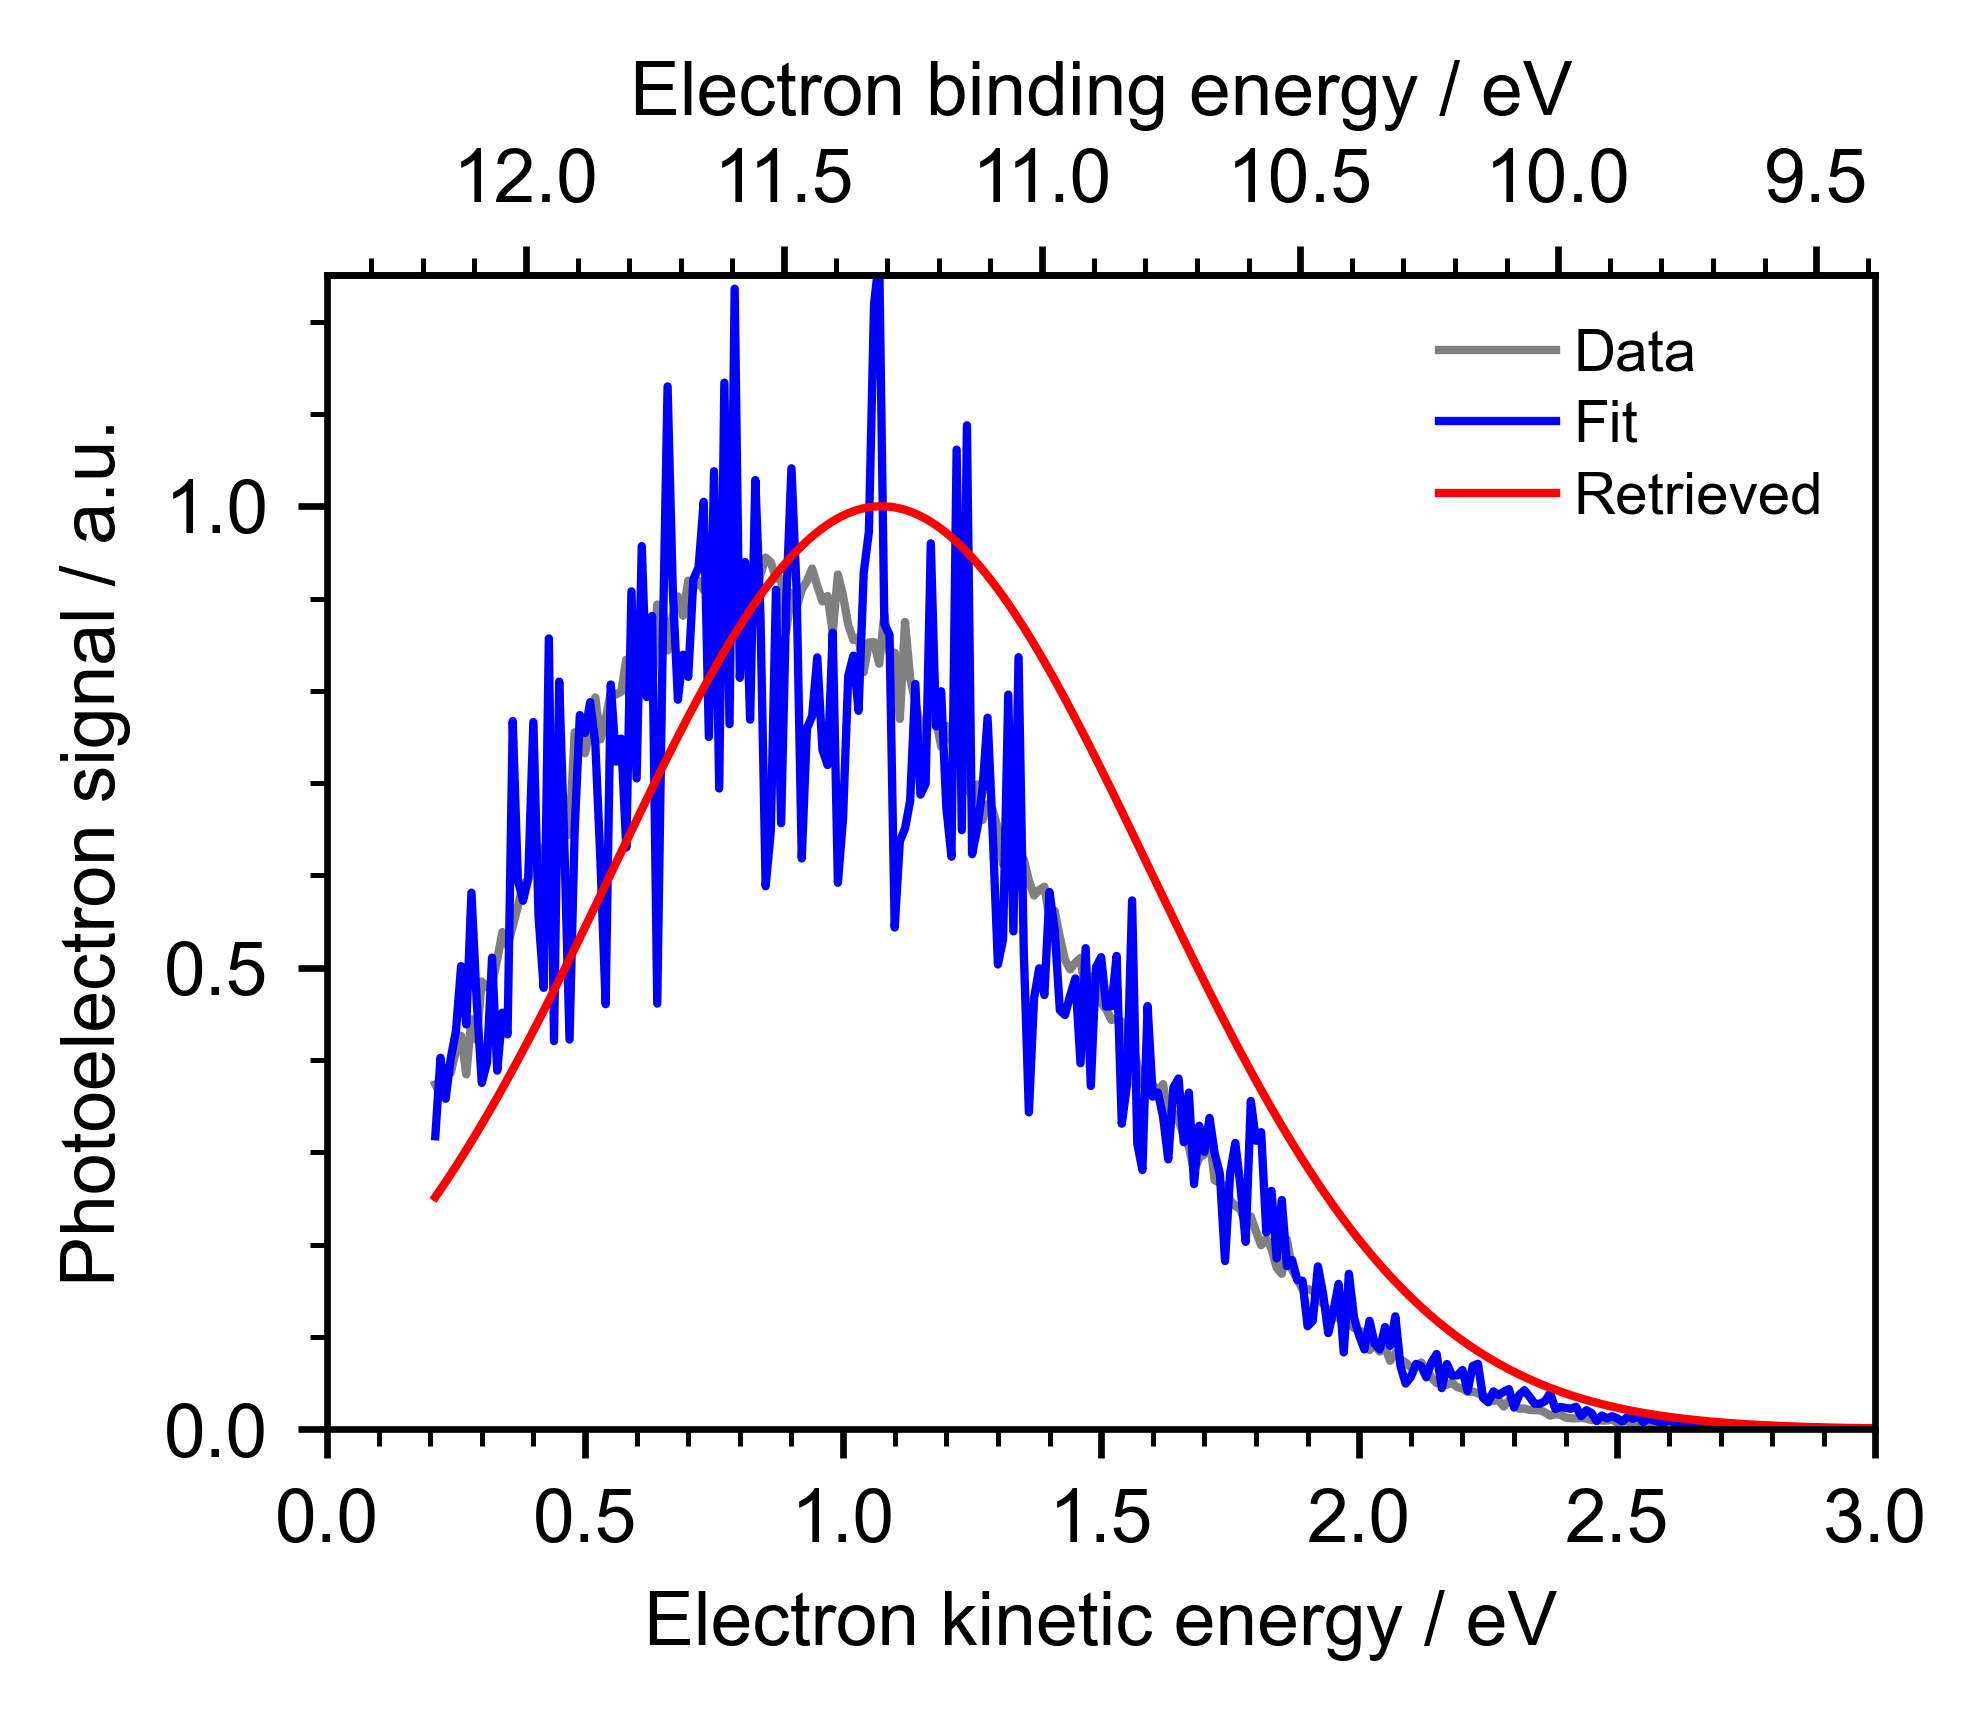

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(ACSwid,ACSwid*0.75)
fig.set_dpi(600)

# Number of photons and wavelength
n_photons=2
wl = 200.2 #nm
# Select data
data=water_data
# Minumum eKE of data
min_eKE = min(data[0])
# Interpolate data
x_above_cutoff,y_above_cutoff = interpolateData(data)

# Pick Gaussian:offset ratio
concAmpInd = 0
print(f"G:y_0 = {concAmps[concAmpInd]}")
#Print(E0)
print(f"E_0 = {E0} eV")
#Pick surface or bulk gaussians
gaussTypes = ['B']
print("Gaussian types:", ", ".join(gaussTypes))

#Correct basis set must be selected
surf_basis = basisSetsNorm[concAmpInd]
bulk_basis = basisSetsNorm[0]
#Create fit function
fitfunc = JetFitFunc(gaussTypes, surf_basis, bulk_basis, min_eKE)
# Fit function
fit,covar = curve_fit(fitfunc.f, xs, y_above_cutoff,
                      p0=[1, 1, 1.1],
                      bounds=(0, np.inf)
                      )
#Plot data and results
ax.plot(x_above_cutoff,y_above_cutoff, 'gray',label="Data")
ax.plot(x_above_cutoff, fitfunc.f(xs, *fit),'b', label="Fit")
ax.plot(x_above_cutoff, multiple_gaussians(x_above_cutoff, *fit)/fit[0], 'r',label="Retrieved")
#Print results
print("\nResults")
print("eKE",[float(f"{f:.2f}") for f in fit])
print("STD",[float(f"{f:.1}") for f in np.sqrt(np.diag(covar))])
print("eBE",[float(f"{n_photons*1239.8/wl-f:.2f}") for f in fit[1::3]])

# Format plot
ax.legend(frameon=False)
ax.set_xlim(0,3)
ax.set_ylim(0,1.25)
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

ax_secondary = ax.secondary_xaxis("top", functions = (lambda x: n_photons*1239.8/wl- x, lambda x: n_photons*1239.8/wl - x))
ax_secondary.xaxis.set_major_locator(MultipleLocator(.5))
ax_secondary.xaxis.set_minor_locator(MultipleLocator(.1))


ax.set_ylabel("Photoelectron signal / a.u.")
ax.set_xlabel("Electron kinetic energy / eV")
ax_secondary.set_xlabel("Electron binding energy / eV")